In [5]:
from sklearn.datasets import fetch_olivetti_faces

In [6]:
olivetti_faces = fetch_olivetti_faces(data_home='./face_data', shuffle=True)
print(olivetti_faces.data.shape)
print(olivetti_faces.target.shape)
print(olivetti_faces.images.shape)

(400, 4096)
(400,)
(400, 64, 64)


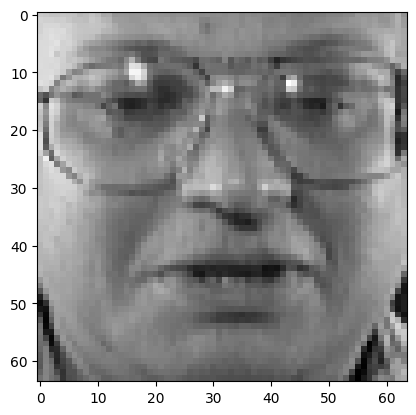

In [7]:
import matplotlib.pyplot as plt

face = olivetti_faces.images[1]
plt.imshow(face, cmap='gray')
plt.show()

In [8]:
olivetti_faces.data[1]

array([0.76859504, 0.75619835, 0.74380165, ..., 0.48347107, 0.6280992 ,
       0.6528926 ], dtype=float32)

In [9]:
olivetti_faces.data[1].shape

(4096,)

In [10]:
olivetti_faces.target

array([13, 30, 34, 19, 24,  6, 15, 26, 14, 21,  3, 13, 11, 34,  1,  5, 29,
       14, 20, 19, 17, 26, 12, 34, 17, 31,  7,  1, 28, 10, 17, 30, 33, 22,
        6,  7,  9, 17, 17, 39, 10, 32,  0,  0, 29,  5, 37, 25, 15, 23, 24,
       14, 29, 17, 28, 31,  5,  1,  2,  4,  7, 27,  0, 35, 19, 37, 14,  0,
       15, 31,  0, 26,  6,  2, 10,  1, 36, 30, 36, 32, 33,  6,  5, 10, 30,
       22, 12, 37, 39, 32, 38, 25,  5,  0, 19, 14, 13, 39, 26, 36, 25,  6,
       31, 15, 28, 34,  8, 34, 15, 29,  9,  8, 29,  2, 36, 21, 25,  4, 23,
       34,  9, 22, 23, 23, 37, 14,  2, 25, 35, 16, 15, 39,  6, 24, 21, 10,
       31, 19, 32,  1, 16, 18,  3, 11, 26, 10, 35, 24, 23, 11, 33, 12, 28,
       11, 21, 13, 27, 12, 19, 29, 28, 13,  3, 37, 16,  3, 23,  9,  8,  6,
       16, 28, 20, 39, 23, 28, 10,  4, 32, 39, 22,  7, 13, 38, 22, 21,  2,
       18, 36, 27,  5, 32, 35,  2,  0, 21, 15, 21, 37, 22, 13, 23, 21, 27,
       27, 30, 23,  3, 20, 39,  6,  2, 33,  4, 24, 12,  9, 11, 16, 38, 38,
       34,  4,  1, 28,  7

In [11]:
olivetti_faces.target.shape

(400,)

In [12]:
import torch
import torch.nn as nn

In [13]:
images = torch.tensor(olivetti_faces.data)
targets = torch.tensor(olivetti_faces.target)

In [14]:
images.shape

torch.Size([400, 4096])

In [15]:
targets.shape

torch.Size([400])

In [16]:
dataset = [(img,lbl) for img,lbl in zip(images, targets)]
dataset[0]

(tensor([0.6694, 0.6364, 0.6488,  ..., 0.0868, 0.0826, 0.0744]),
 tensor(13, dtype=torch.int32))

In [17]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

In [18]:
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [38]:
def build_model_objects(optim_strategy):

    model = nn.Sequential(
        nn.Linear(4096, 8192),
        nn.BatchNorm1d(8192),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(8192, 16384),
        nn.BatchNorm1d(16384),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(16384, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(1024, 40)
    )  # 模型结构搬到GPU内存中
    criterion = nn.CrossEntropyLoss()  # 损失函数
    if optim_strategy == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    elif optim_strategy == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    elif optim_strategy == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    else:
        raise ValueError("Invalid optimization strategy")
    return model, criterion, optimizer

In [40]:
loss_hist = {}

for optimizer_name in ['SGD', 'RMSprop', 'Adam']:

    model, criterion, optimizer = build_model_objects(optimizer_name)
    loss_hist[optimizer_name] = []
    model.to(device)  # 模型搬到GPU内存中

    model.train()
    for i in range(4):
        for img,lbl in dataloader:
            img,lbl = img.to(device), lbl.to(device)  # 数据和模型在同一个设备端
            lbl = lbl.long() 
            result = model(img)
            loss = criterion(result, lbl)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist[optimizer_name].append(loss.item())
            print(f'epoch:{i+1} optimizer:{optimizer_name} loss:{loss.item():.4f}')

epoch:1 optimizer:SGD loss:3.7624
epoch:1 optimizer:SGD loss:3.8022
epoch:1 optimizer:SGD loss:3.4341
epoch:1 optimizer:SGD loss:3.8807
epoch:1 optimizer:SGD loss:3.7336
epoch:1 optimizer:SGD loss:3.9634
epoch:1 optimizer:SGD loss:3.5828
epoch:1 optimizer:SGD loss:3.6293
epoch:1 optimizer:SGD loss:3.6563
epoch:1 optimizer:SGD loss:3.8448
epoch:1 optimizer:SGD loss:3.8094
epoch:1 optimizer:SGD loss:3.8071
epoch:1 optimizer:SGD loss:4.1291
epoch:1 optimizer:SGD loss:3.7773
epoch:1 optimizer:SGD loss:3.3738
epoch:1 optimizer:SGD loss:3.5573
epoch:1 optimizer:SGD loss:3.2486
epoch:1 optimizer:SGD loss:3.6290
epoch:1 optimizer:SGD loss:3.6053
epoch:1 optimizer:SGD loss:3.8029
epoch:1 optimizer:SGD loss:3.8619
epoch:1 optimizer:SGD loss:3.7413
epoch:1 optimizer:SGD loss:3.6181
epoch:1 optimizer:SGD loss:3.7750
epoch:1 optimizer:SGD loss:3.7817
epoch:1 optimizer:SGD loss:3.9636
epoch:1 optimizer:SGD loss:3.4811
epoch:1 optimizer:SGD loss:3.6700
epoch:1 optimizer:SGD loss:3.7437
epoch:1 optimi

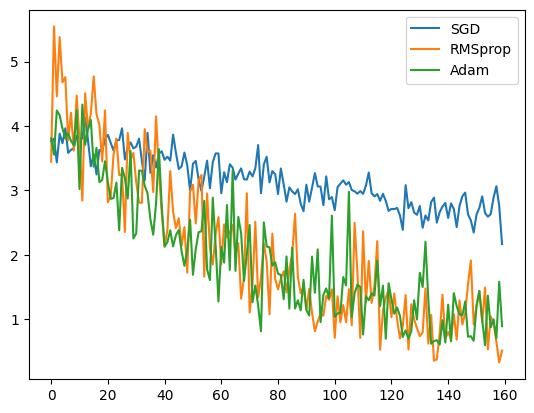

In [42]:
for opt in ['SGD', 'RMSprop', 'Adam']:
    plt.plot(range(len(loss_hist[opt])), loss_hist[opt], label=opt)
    plt.legend()
plt.show()